# **S&P 500 Prediction Using Dependent Gaussian Data**  

## **License**  
This project is released under the **GNU General Public License v3 (GPLv3)**.  
You are free to use, modify, and distribute this code under the terms of the GPLv3 license.  
For more details, see: [GNU GPL v3](https://www.gnu.org/licenses/gpl-3.0.en.html).  

## **Authors**  
- **Mina Sadat Mahmoudi**  
- **Saeed Foroutan**  
- **Seyed Abolfazl Motahari**  
- **Babak Khalaj**  
- Department of Electrical Engineering & Computer Engineering, Sharif University of Technology, Iran  

## **Conference & Publication**  
This work has been **accepted for presentation at ICASSP 2025**.  

---

## **Overview**  

This notebook applies the theoretical findings from the paper:

📄 **"Uniform Convergence of Lipschitz Functions with Dependent Gaussian Samples"**  
(*ICASSP 2025, Sharif University of Technology*)  

### **Objective**  
- Predict **S&P 500 index values** using **dependent financial data**.  
- Train a **deep learning model** to forecast stock market trends.  
- Analyze the impact of **temporal dependence** on prediction accuracy.  

### **Methodology**  
- Utilize **historical S&P 500 data** with financial indicators.  
- Train a **neural network** to learn patterns in stock price movements.  
- Compare prediction performance under **different dependency structures** (`γ`).  

This analysis explores how **financial time series data**, which inherently exhibits strong dependencies, aligns with the **theoretical results** on learning from **correlated samples**.


### **In this Notebook Because of a high similarity with other notebook we just explain required cells**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import random
import seaborn as sn

In [ ]:
def tensorize(x):
  return torch.tensor(x, dtype=torch.float32).unsqueeze(1)


In [ ]:
# Define a deeper neural network with more layers and neurons
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(1, 128)  # Input layer to first hidden layer (128 neurons)
        self.fc2 = nn.Linear(128, 256)  # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(256, 512)  # Second hidden layer to third hidden layer
        self.fc4 = nn.Linear(512, 256)  # Third hidden layer to fourth hidden layer
        self.fc5 = nn.Linear(256, 128)  # Fourth hidden layer to fifth hidden layer
        self.fc6 = nn.Linear(128, 64)   # Fifth hidden layer to sixth hidden layer
        self.fc7 = nn.Linear(64, 1)     # Sixth hidden layer to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x


In [ ]:
# Initialize the neural network
model = DeepNN()

# Define the loss function (Mean absolute error as shown in the equation)
def custom_loss(output, target):
    return torch.mean(torch.abs(output - target))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_model(x,y,model):
  x_tensor, y_tensor = tensorize(x), tensorize(y)

  # Train the model
  num_epochs = 2000
  for epoch in range(num_epochs):
      model.train()

      # Forward pass
      outputs = model(x_tensor)
      loss = custom_loss(outputs, y_tensor)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print loss every 100 epochs
      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
  return model


In [ ]:
def predict(model, input):

    model.eval()


    output = model(input).detach().numpy()

    return output


## **Step 1: Download Stock Data Using `yfinance`**  

This function retrieves **historical stock price data** from **Yahoo Finance (`yfinance`)** for a given **ticker** within a specified date range.  

### **Function: `download_stock_data(ticker, start_date, end_date)`**  
- **Inputs:**  
  - `ticker` → Stock symbol (e.g., `"^GSPC"` for S&P 500).  
  - `start_date` → Beginning of the data period.  
  - `end_date` → End of the data period.  
- **Process:**  
  - Downloads **daily stock prices** using the `yfinance.download()` method.  
  - Fills any **missing values** using **forward fill (`ffill`)** to handle gaps in trading data.  
- **Output:**  
  - Returns a **DataFrame** containing historical stock data, including **Open, High, Low, Close, and Volume**.  

This step ensures that we have a **clean and continuous dataset** for stock market prediction.


In [ ]:
# Step 1: Download stock data using yfinance
def download_stock_data(ticker, start_date, end_date):
    # Download stock data from yfinance
    stock_data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    stock_data.fillna(method='ffill')
    return stock_data



In [ ]:
main_list = []

**Sample: 50**

## **Step 2: Preparing Training and Testing Data**  

This section retrieves, preprocesses, and normalizes **S&P 500 stock data** for model training and evaluation.

---

### **1️⃣ Data Collection**  
- **Train Dataset**:  
  - **Start Date:** ~27 years ago (~10,000 days)  
  - **End Date:** ~9928 days ago  
- **Test Dataset**:  
  - **Start Date:** ~9899 days ago  
  - **End Date:** Today  

Our goal is that the train data size will be 50.

We use the **closing price** as input (`X`) and the **trading volume** as output (`y`).

We will iterate the same procedure for next sizes.

---

### **2️⃣ Data Normalization**  
To ensure stable training, we **normalize** both inputs (`Close Price`) and outputs (`Volume`) using **min-max scaling**:

$$
X_{\text{norm}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

This transformation ensures values are within **[0,1]**, improving model convergence.

---

### **3️⃣ Model Training & Prediction**  
- A **neural network model** is trained on `input_train_norm` and `output_train_norm`.  
- The trained model is then used to **predict stock trading volume** based on unseen test data.

---

### **4️⃣ Random Sampling for Error Analysis**  
- **500 random test points** are selected.  
- **Constraint:** Each random point (`rnd`) is at least **3 days apart** from previously selected points to ensure diverse samples.  
- **Prediction Process:**  
  - Extract **closing price (`X_test`)** for the selected day.  
  - Predict **trading volume (`y_pred`)** using the trained model.  
  - Compute **absolute error** between predicted and actual values.



In [ ]:
end_date_train = datetime.now() - timedelta(days=9928)
start_date_train = datetime.now() - timedelta(days=10000)

end_date_test = datetime.now()
start_date_test = datetime.now() - timedelta(days=9899)
ticker = '^GSPC'

In [ ]:
stock_data_train = download_stock_data(ticker, start_date_train, end_date_train)
stock_data_test = download_stock_data(ticker, start_date_test, end_date_test)
input_train = stock_data_train['Close'].to_numpy()
output_train = stock_data_train['Volume'].to_numpy()
input_test = stock_data_test['Close'].to_numpy()
output_test = stock_data_test['Volume'].to_numpy()
input_train_norm = (input_train - np.min(input_train)) / (np.max(input_train) - np.min(input_train))
output_train_norm = (output_train - np.min(output_train)) / (np.max(output_train) - np.min(output_train))
input_test_norm = (input_test - np.min(input_test)) / (np.max(input_test) - np.min(input_test))
output_test_norm = (output_test - np.min(output_test)) / (np.max(output_test) - np.min(output_test))
print(len(input_train_norm))

[*********************100%***********************]  1 of 1 completed
<ipython-input-42-5443a2374d1b>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed

50



<ipython-input-42-5443a2374d1b>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill')


In [ ]:
print(len(input_train_norm))
print(len(output_train_norm))
print(len(input_test_norm))
print(len(output_test_norm))

50
50
6819
6819


In [ ]:
trained_model = train_model(input_train_norm,output_train_norm,model)

Epoch [100/2000], Loss: 0.1450
Epoch [200/2000], Loss: 0.1430
Epoch [300/2000], Loss: 0.1392
Epoch [400/2000], Loss: 0.1333
Epoch [500/2000], Loss: 0.1260
Epoch [600/2000], Loss: 0.1195
Epoch [700/2000], Loss: 0.1189
Epoch [800/2000], Loss: 0.1179
Epoch [900/2000], Loss: 0.1180
Epoch [1000/2000], Loss: 0.1180
Epoch [1100/2000], Loss: 0.1179
Epoch [1200/2000], Loss: 0.1179
Epoch [1300/2000], Loss: 0.1174
Epoch [1400/2000], Loss: 0.1176
Epoch [1500/2000], Loss: 0.1175
Epoch [1600/2000], Loss: 0.1170
Epoch [1700/2000], Loss: 0.1171
Epoch [1800/2000], Loss: 0.1169
Epoch [1900/2000], Loss: 0.1167
Epoch [2000/2000], Loss: 0.1170


In [ ]:
predicted_values = []
actual_values = []
sum_error = []
iterations = 500
list_of_rnds = []

for i in range(iterations):
    rnd = random.randint(0, 6800)

    # Check if rnd is within 20 numbers of any existing rnd in list_of_rnds
    while any(abs(rnd - previous_rnd) <= 3 for previous_rnd in list_of_rnds):
        rnd = random.randint(0, 6800)

    list_of_rnds.append(rnd)

    # Continue with the rest of your operations
    x1 = np.array([input_test_norm[rnd]])
    y1 = np.array([output_test_norm[rnd]])
    y_pred1 = predict(trained_model, tensorize(x1))

    predicted_values.append(y_pred1[0][0])
    actual_values.append(y1[0])
    sum_error.append(abs(y1[0] - y_pred1[0][0]))

In [ ]:
main_list.append(sum_error)

**Sample: 200**

In [ ]:
end_date_train = datetime.now() - timedelta(days=9711)
start_date_train = datetime.now() - timedelta(days=10000)

end_date_test = datetime.now()
start_date_test = datetime.now() - timedelta(days=9599)

stock_data_train = download_stock_data(ticker, start_date_train, end_date_train)
stock_data_test = download_stock_data(ticker, start_date_test, end_date_test)
input_train = stock_data_train['Close'].to_numpy()
output_train = stock_data_train['Volume'].to_numpy()
input_test = stock_data_test['Close'].to_numpy()
output_test = stock_data_test['Volume'].to_numpy()
input_train_norm = (input_train - np.min(input_train)) / (np.max(input_train) - np.min(input_train))
output_train_norm = (output_train - np.min(output_train)) / (np.max(output_train) - np.min(output_train))
input_test_norm = (input_test - np.min(input_test)) / (np.max(input_test) - np.min(input_test))
output_test_norm = (output_test - np.min(output_test)) / (np.max(output_test) - np.min(output_test))
print(len(input_train_norm))

[*********************100%***********************]  1 of 1 completed
<ipython-input-42-5443a2374d1b>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed

200



<ipython-input-42-5443a2374d1b>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill')


In [ ]:
print(len(input_train_norm))
print(len(output_train_norm))
print(len(input_test_norm))
print(len(output_test_norm))

200
200
6613
6613


In [ ]:
trained_model = train_model(input_train_norm,output_train_norm,model)

Epoch [100/2000], Loss: 0.0616
Epoch [200/2000], Loss: 0.0600
Epoch [300/2000], Loss: 0.0595
Epoch [400/2000], Loss: 0.0591
Epoch [500/2000], Loss: 0.0588
Epoch [600/2000], Loss: 0.0586
Epoch [700/2000], Loss: 0.0584
Epoch [800/2000], Loss: 0.0582
Epoch [900/2000], Loss: 0.0582
Epoch [1000/2000], Loss: 0.0581
Epoch [1100/2000], Loss: 0.0580
Epoch [1200/2000], Loss: 0.0580
Epoch [1300/2000], Loss: 0.0579
Epoch [1400/2000], Loss: 0.0579
Epoch [1500/2000], Loss: 0.0579
Epoch [1600/2000], Loss: 0.0578
Epoch [1700/2000], Loss: 0.0578
Epoch [1800/2000], Loss: 0.0577
Epoch [1900/2000], Loss: 0.0578
Epoch [2000/2000], Loss: 0.0575


In [ ]:
predicted_values = []
actual_values = []
sum_error = []
iterations = 500
list_of_rnds = []

for i in range(iterations):
    rnd = random.randint(0, 6600)

    # Check if rnd is within 20 neighbors of any number in list_of_rnds
    while any(abs(rnd - previous_rnd) <= 3 for previous_rnd in list_of_rnds):
        rnd = random.randint(0, 6600)

    list_of_rnds.append(rnd)

    # Use rnd to select values and predict
    x1 = np.array([input_test_norm[rnd]])
    y1 = np.array([output_test_norm[rnd]])
    y_pred1 = predict(trained_model, tensorize(x1))

    predicted_values.append(y_pred1[0][0])
    actual_values.append(y1[0])
    sum_error.append(abs(y1[0] - y_pred1[0][0]))

In [ ]:
main_list.append(sum_error)

**Sample: 1000**

In [ ]:
end_date_train = datetime.now() - timedelta(days=8551)
start_date_train = datetime.now() - timedelta(days=10000)

end_date_test = datetime.now()
start_date_test = datetime.now() - timedelta(days=8399)

stock_data_train = download_stock_data(ticker, start_date_train, end_date_train)
stock_data_test = download_stock_data(ticker, start_date_test, end_date_test)
input_train = stock_data_train['Close'].to_numpy()
output_train = stock_data_train['Volume'].to_numpy()
input_test = stock_data_test['Close'].to_numpy()
output_test = stock_data_test['Volume'].to_numpy()
input_train_norm = (input_train - np.min(input_train)) / (np.max(input_train) - np.min(input_train))
output_train_norm = (output_train - np.min(output_train)) / (np.max(output_train) - np.min(output_train))
input_test_norm = (input_test - np.min(input_test)) / (np.max(input_test) - np.min(input_test))
output_test_norm = (output_test - np.min(output_test)) / (np.max(output_test) - np.min(output_test))
print(len(input_train_norm))

[*********************100%***********************]  1 of 1 completed
<ipython-input-42-5443a2374d1b>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed

1000



<ipython-input-42-5443a2374d1b>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill')


In [ ]:
print(len(input_train_norm))
print(len(output_train_norm))
print(len(input_test_norm))
print(len(output_test_norm))

1000
1000
5787
5787


In [ ]:
trained_model = train_model(input_train_norm,output_train_norm,model)

Epoch [100/2000], Loss: 0.0664
Epoch [200/2000], Loss: 0.0661
Epoch [300/2000], Loss: 0.0660
Epoch [400/2000], Loss: 0.0659
Epoch [500/2000], Loss: 0.0658
Epoch [600/2000], Loss: 0.0657
Epoch [700/2000], Loss: 0.0657
Epoch [800/2000], Loss: 0.0655
Epoch [900/2000], Loss: 0.0655
Epoch [1000/2000], Loss: 0.0654
Epoch [1100/2000], Loss: 0.0653
Epoch [1200/2000], Loss: 0.0653
Epoch [1300/2000], Loss: 0.0652
Epoch [1400/2000], Loss: 0.0652
Epoch [1500/2000], Loss: 0.0651
Epoch [1600/2000], Loss: 0.0651
Epoch [1700/2000], Loss: 0.0650
Epoch [1800/2000], Loss: 0.0651
Epoch [1900/2000], Loss: 0.0649
Epoch [2000/2000], Loss: 0.0649


In [ ]:
predicted_values = []
actual_values = []
sum_error = []
iterations = 500
list_of_rnds = []

for i in range(iterations):
    rnd = random.randint(0, 5500)

    # Check if rnd is within 20 neighbors of any number in list_of_rnds
    while any(abs(rnd - previous_rnd) <= 3 for previous_rnd in list_of_rnds):
        rnd = random.randint(0, 5500)

    list_of_rnds.append(rnd)

    # Use rnd to select values and predict
    x1 = np.array([input_test_norm[rnd]])
    y1 = np.array([output_test_norm[rnd]])
    y_pred1 = predict(trained_model, tensorize(x1))

    predicted_values.append(y_pred1[0][0])
    actual_values.append(y1[0])
    sum_error.append(abs(y1[0] - y_pred1[0][0]))

In [ ]:
main_list.append(sum_error)

In [ ]:
print(sum(main_list[0])/len(main_list[0]))
print(sum(main_list[1])/len(main_list[1]))
print(sum(main_list[2])/len(main_list[2]))

0.2957396919317959
0.13212297837821352
0.09878942569045562




### **Computed Absolute Error Values**
| **Sample Size** | **Average Absolute Prediction Error** |
|---------------|----------------------------------|
| **50 samples**  | **0.2957** |
| **200 samples** | **0.1321** |
| **1000 samples** | **0.0988** |

---



In [ ]:
data2 = main_list

<ipython-input-64-887a207ab86a>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  box.set_xticklabels(['69', '275', '1103','6000'], fontsize=12)


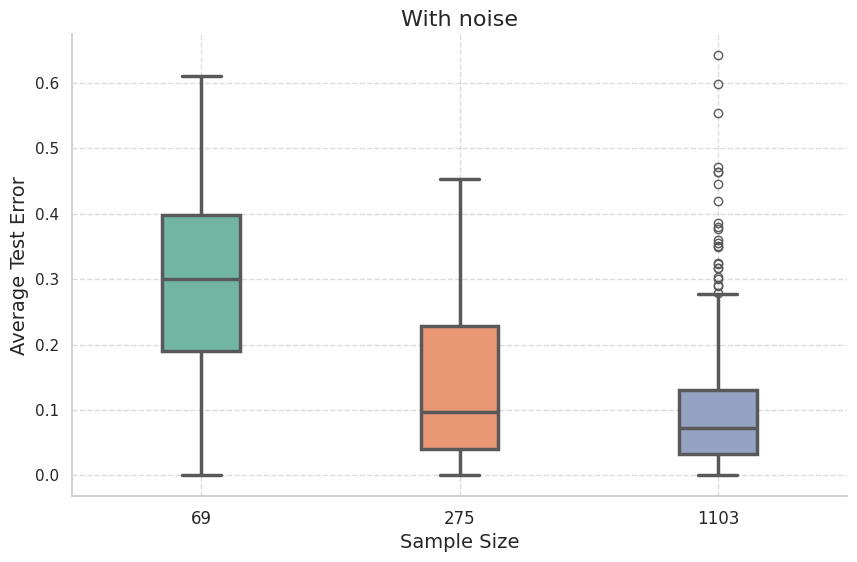

In [ ]:
plt.rcParams["font.family"] = "Times New Roman"
# Create a box plot with adjusted box width
plt.figure(figsize=(10, 6))  # Set the figure size

# Create boxplot with a clean style and slimmer boxes
sn.set(style="whitegrid")
box = sn.boxplot(data=data2, palette="Set2", linewidth=2.5, width=0.3)  # Adjust the 'width' parameter

# Customize the appearance
box.set_title('With noise', fontsize=16)
box.set_xlabel('Sample Size', fontsize=14)
box.set_ylabel('Average Test Error', fontsize=14)
box.set_xticklabels(['69', '275', '1103','6000'], fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Remove individual data points for a cleaner look
sn.despine()

# Show the plot
plt.show()